In [1]:
from torch import nn
import matplotlib.pyplot as plt


class ThreeLayerCnn(nn.Module):
    def __init__(self):
        super(ThreeLayerCnn, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)

        self.fc2 = nn.Linear(128, 3)

        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # B, 256, 256 -> B, 256, 256, 16
        x = self.max_pool2d(x)  # B, 256, 256, 16 -> B, 128, 128, 16
        x = self.relu(self.conv2(x))  # B, 128, 128, 16 -> B, 128, 128, 32
        x = self.max_pool2d(x)  # B, 128, 128, 32 -> B, 64, 64, 32
        x = self.relu(self.conv3(x))  # B, 64, 64, 32 -> B, 64, 64, 64
        x = self.max_pool2d(x)  # B, 64, 64, 64 -> B, 32, 32, 64
        x = x.view(x.size(0), -1)  # B, 32, 32, 64 -> B, 32 * 32 * 64
        x = self.relu(self.fc1(x))  # B, 32 * 32 * 64 -> B, 128
        x = self.fc2(x)  # B, 128 -> B, 3
        return x

    def visualise_feature_maps(self, x, layer_idx):
        # Add batch dimension if needed
        if x.dim() == 3:
            x = x.unsqueeze(0)

        if layer_idx == 1:
            x = self.relu(self.conv1(x))
        elif layer_idx == 2:
            x = self.relu(self.conv1(x))
            x = self.max_pool2d(x)
            x = self.relu(self.conv2(x))
        elif layer_idx == 3:
            x = self.relu(self.conv1(x))
            x = self.max_pool2d(x)
            x = self.relu(self.conv2(x))
            x = self.max_pool2d(x)
            x = self.relu(self.conv3(x))
        else:
            raise ValueError("Layer index must be between 1 and 3")

        feature_maps = x.detach().cpu().numpy()
        print(feature_maps.shape)

        # Get the feature maps from the first batch (batch_size, channels, height, width)
        # We want to display the channels, so we take feature_maps[0] to get (channels, height, width)
        feature_maps = feature_maps[0]  # Shape: (num_channels, height, width)
        num_filters = feature_maps.shape[0]
        print(f"Num filters: {num_filters}")

        fig, axes = plt.subplots(
            2, 8, figsize=(32, 12)
        )  # Display up to 8 filters in 2x4 grid
        axes = axes.flatten()  # Flatten to make indexing easier

        for i in range(num_filters):  # Always iterate through 8 positions
            if i < num_filters:
                axes[i].imshow(
                    feature_maps[i], cmap="viridis"
                )  # Display the i-th feature map
                axes[i].set_title(f"Filter {i + 1}", fontsize=48)
                axes[i].axis("off")
            else:
                axes[i].axis("off")  # Turn off empty subplots
        plt.tight_layout()
        plt.show()

In [2]:
import os
import torch
from torchvision import transforms
from PIL import Image

In [3]:
data_dir = "../data/pngs_png_cropped_bin1"
# open up random file in data_dir
file = os.listdir(data_dir)[0]
# compress image to 256x256 using torchvision
img = Image.open(os.path.join(data_dir, file)).convert("L")
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
img = transform(img)

model = ThreeLayerCnn()
model.eval()

# open and load checkpoint
checkpoint_path = "../checkpoints/paper_250_binary/epoch=456-val_loss=0.000906.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
model_state_dict = checkpoint["state_dict"]

model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [4]:
img.shape

torch.Size([1, 256, 256])

(1, 16, 256, 256)
Num filters: 16


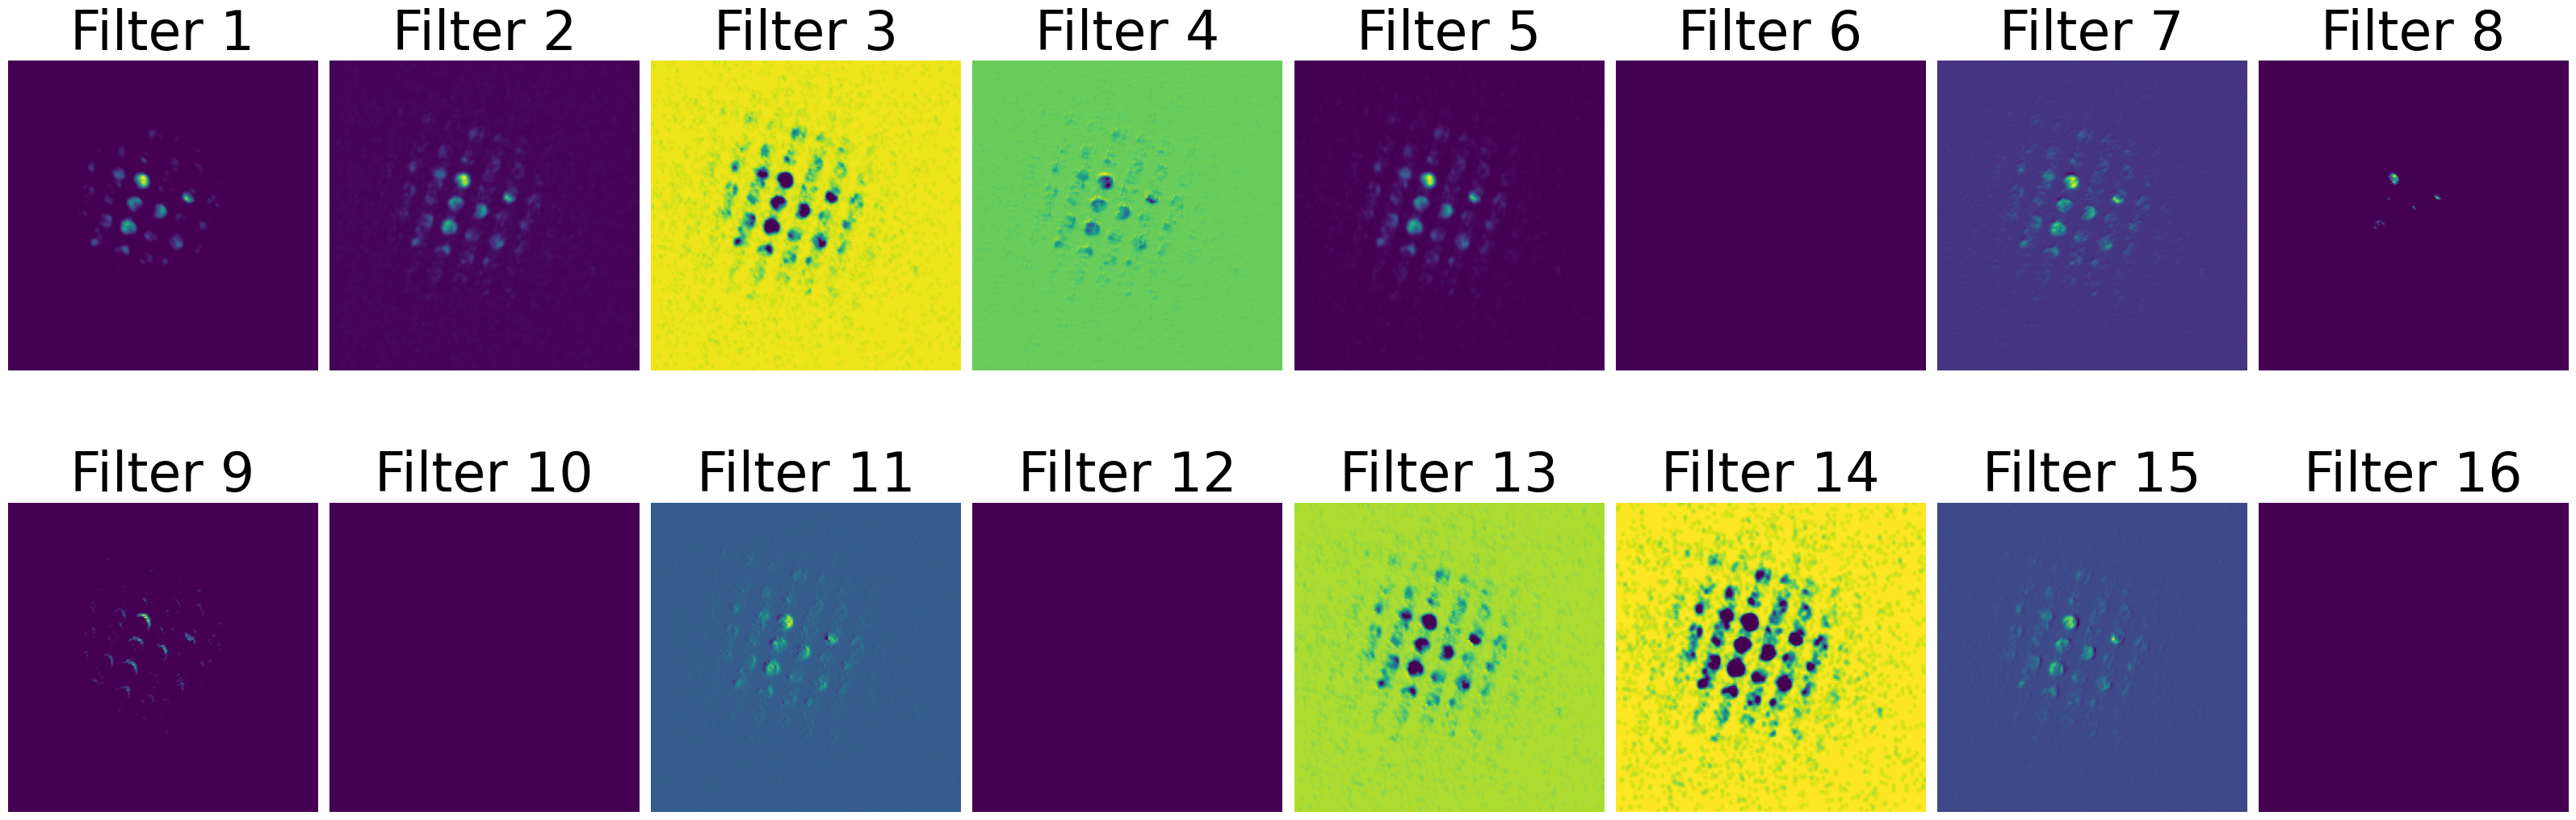

In [5]:
model.visualise_feature_maps(img, layer_idx=1)

(1, 32, 128, 128)
Num filters: 32


IndexError: index 16 is out of bounds for axis 0 with size 16

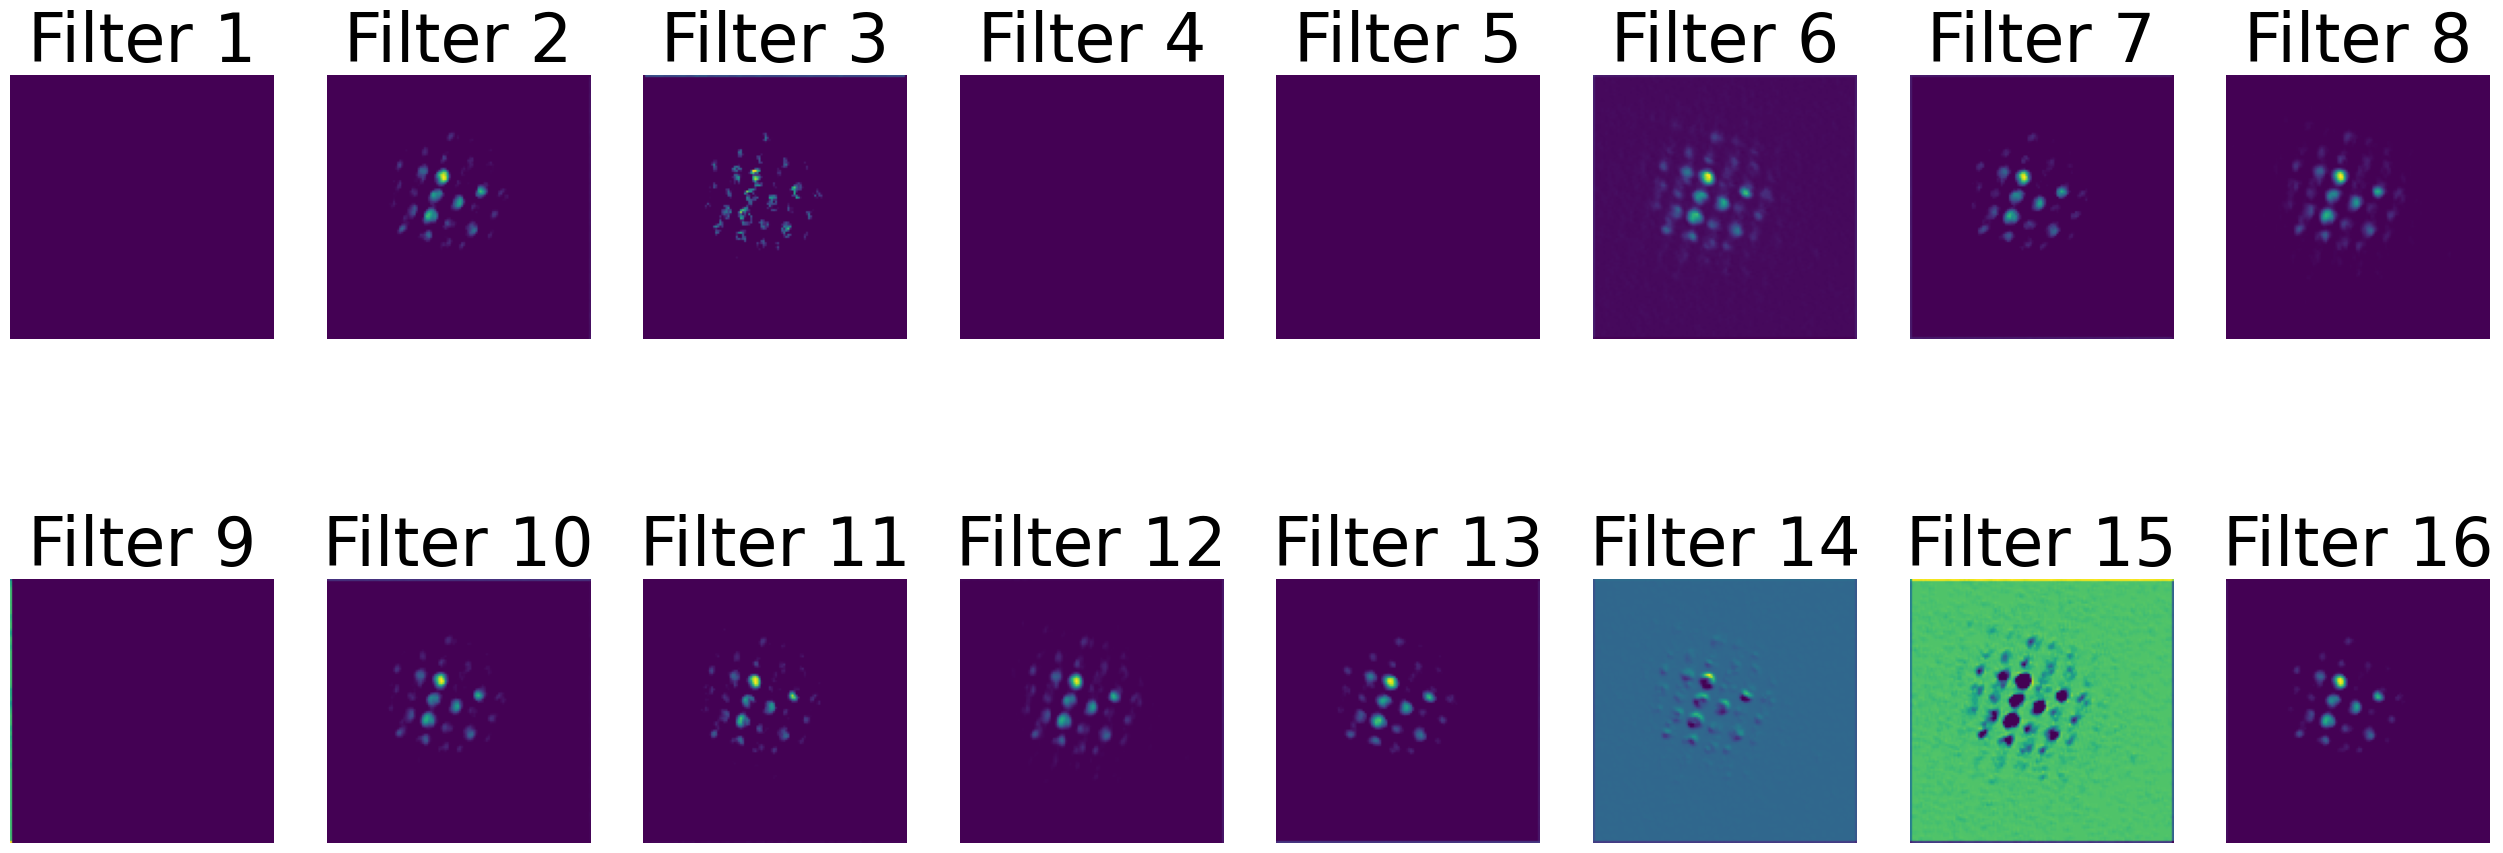

In [6]:
model.visualise_feature_maps(img, layer_idx=2)

(1, 64, 64, 64)
Num filters: 64


IndexError: index 32 is out of bounds for axis 0 with size 32

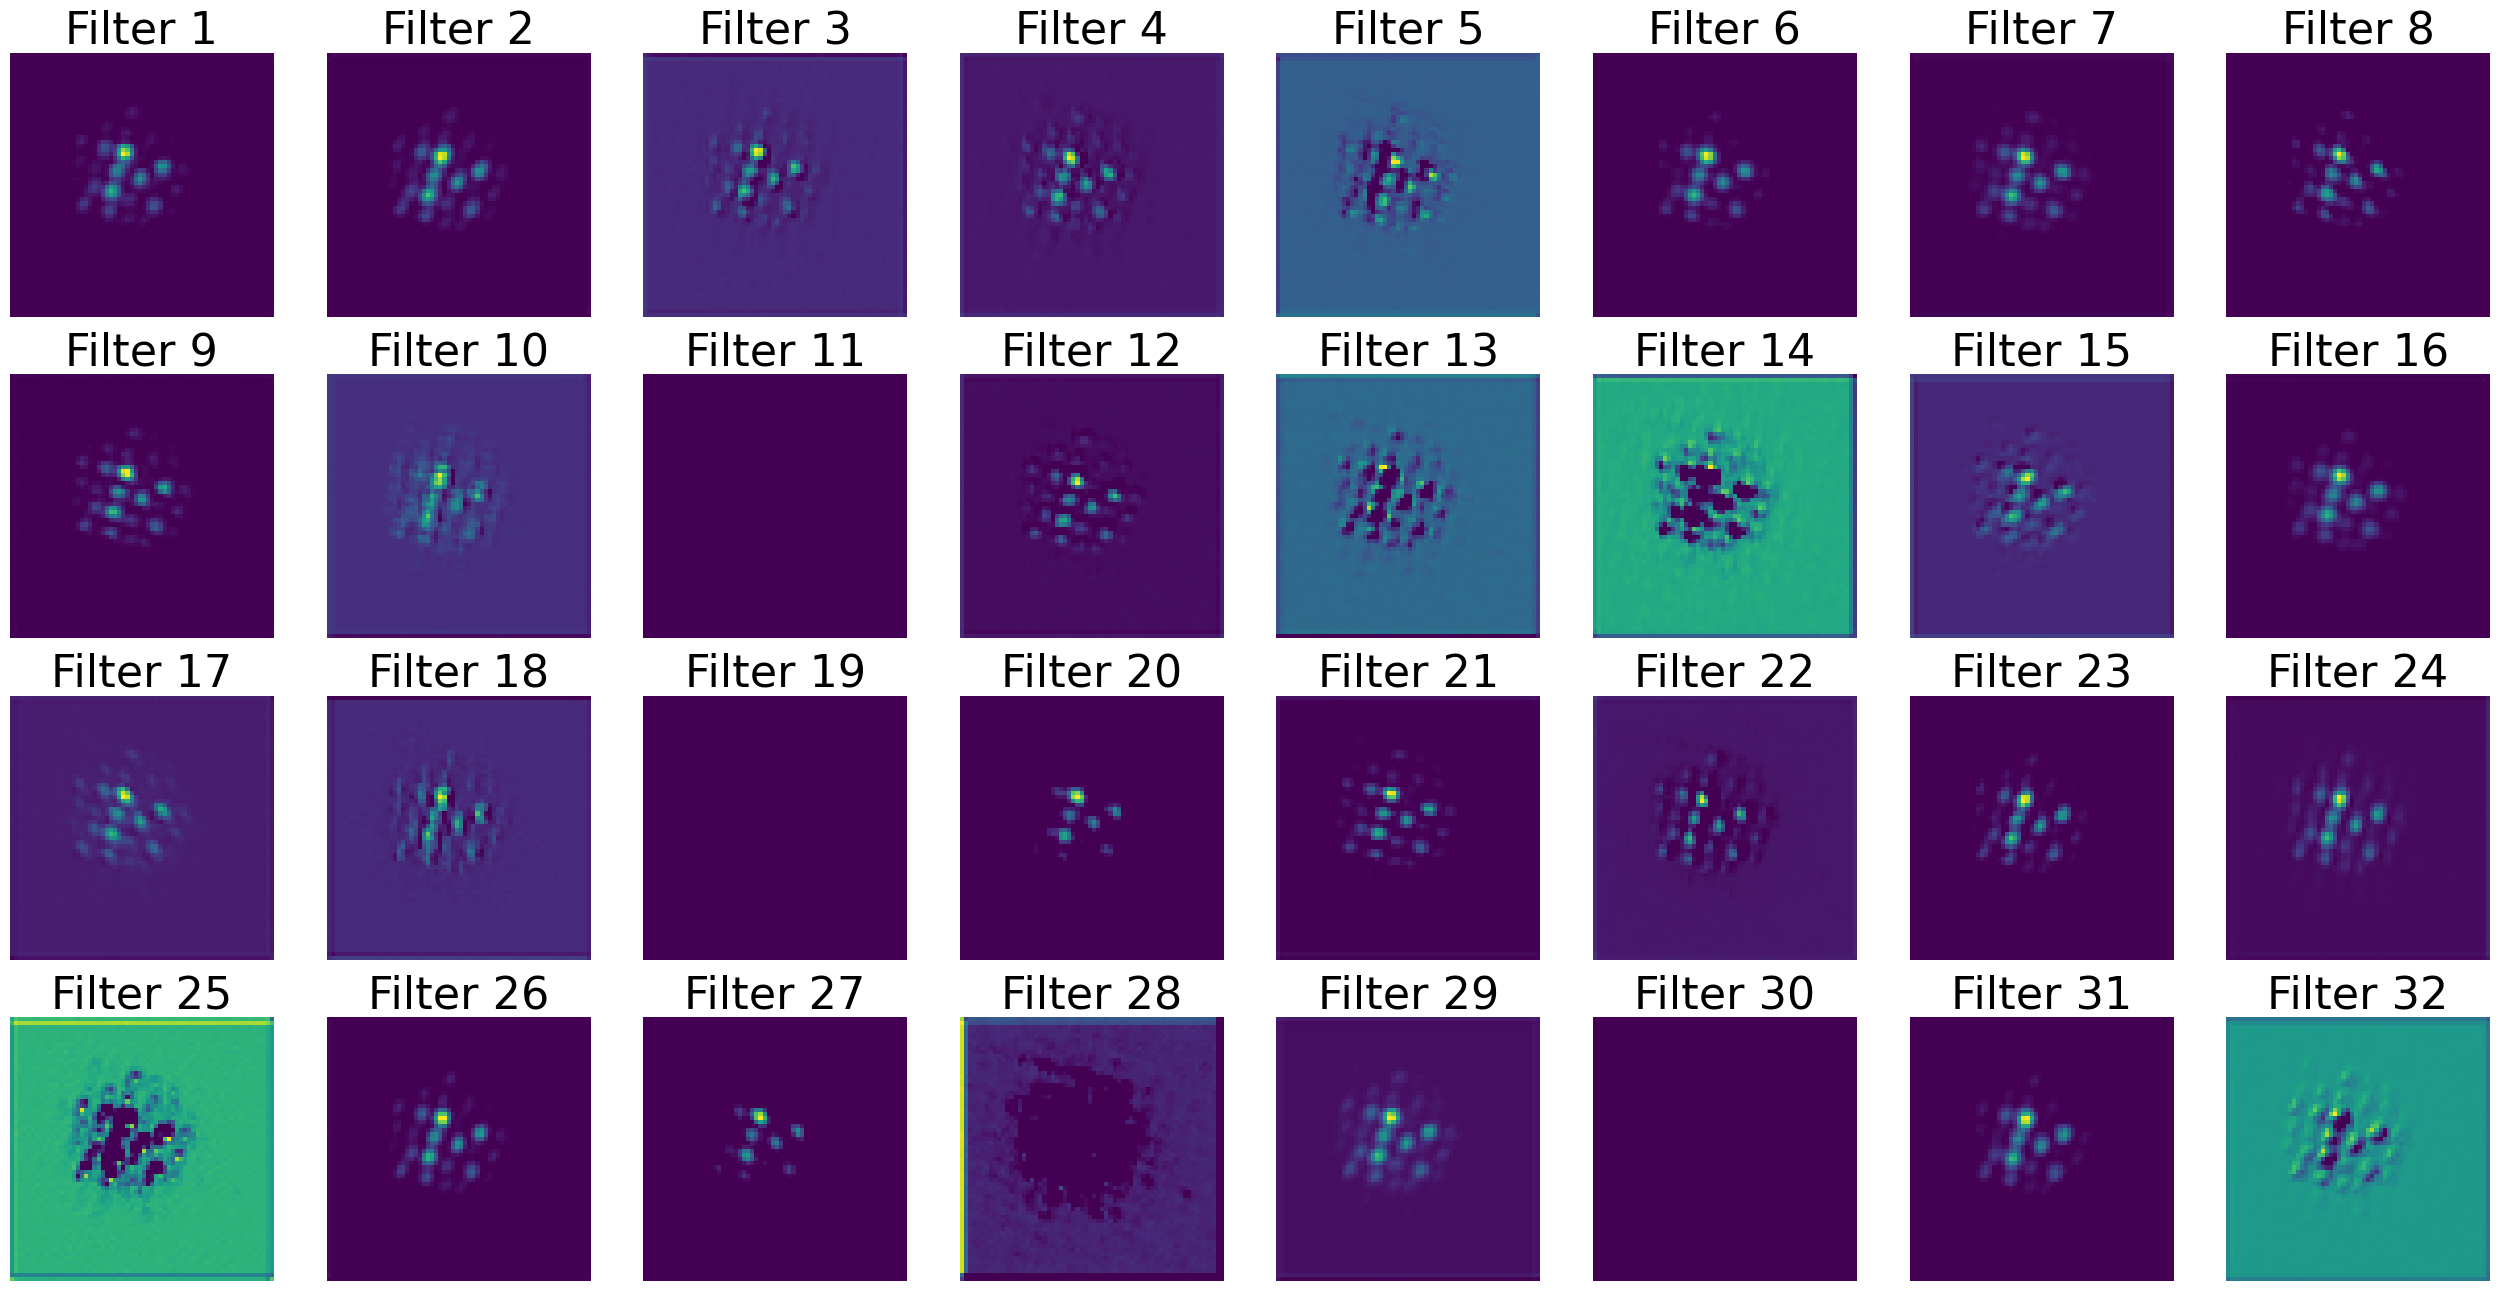

In [ ]:
model.visualise_feature_maps(img, layer_idx=3)
